In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os.path


In [7]:


dataset = './data/nqh23_15sec.csv'
tick_data = './data/NQ 06-23.Last.csv'
if os.path.isfile(dataset):
    df1 = pd.read_csv(dataset)

else:
    header = ('date','last')
    df = pd.read_csv(tick_data, delimiter=';', usecols=[0,1], header=None, names=header)
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d %H%M%S %f', utc = True)
    df1 = df.resample("15s", on = 'date',).ohlc()['last']
    df1.dropna(inplace=True)
    df1.to_csv(dataset)

df1.head()

,open,high,low,close
date,,,,
2023-03-13 04:00:00+00:00,12177.25,12179.00,12177.25,12179.00
2023-03-13 04:00:15+00:00,12179.00,12179.25,12179.00,12179.25
2023-03-13 04:00:30+00:00,12181.25,12181.25,12180.25,12180.75
2023-03-13 04:00:45+00:00,12179.50,12179.75,12179.25,12179.75
2023-03-13 04:01:00+00:00,12180.00,12181.75,12180.00,12180.50


In [8]:



# Candle color features
df1['green'] = (df1['open'] < df1['close']).astype(int)
df1['red'] = (df1['open'] > df1['close']).astype(int)
df1['dodgy'] = (df1['open'] == df1['close']).astype(int)


#Candle budy features
df1['full_body'] = (abs(df1['close'] - df1['open'])/(df1['high'] - df1['low']) >= 0.8).astype(int)
df1['good_body'] = (abs(df1['close'] - df1['open'])/(df1['high'] - df1['low']) >= 0.3).astype(int)
df1['small_body'] = (abs(df1['close'] - df1['open'])/(df1['high'] - df1['low']) < 0.3).astype(int)
df1['upper_body'] = (((df1['high'] == df1['close']) & (df1['low'] != df1['open'])) | 
                    ((df1['high'] == df1['open']) & (df1['low'] != df1['close']))).astype(int)
df1['lower_body'] = (((df1['high'] != df1['close']) & (df1['low'] == df1['open'])) | 
                    ((df1['high'] != df1['open']) & (df1['low'] == df1['close']))).astype(int)
#df1['ratio'] = ((df1['high'] - df1['low']) > (df1['high'].shift(1) - df1['low'].shift(1))).astype(int)
                    

# Function generating multiplicator string for binary features conversion to a candle class number
def mult_row (x):
    raw = []
    for i in range(x-1,-1,-1):
        raw.append(2**i)
        
    return raw
# Class definition for each candle based on candles features binary threatment
df1['class'] = np.sum(df1.iloc[:,4:].values * mult_row(df1.iloc[:,4:].values.shape[1]),axis=1,keepdims=True)

# Class simplification based on unic class ID
cdl_classes  = sorted(set(df1['class'].values))
cltoi = {s:i for i,s in enumerate(cdl_classes)}
df1['class'] = df1['class'].apply(lambda x : cltoi[x])
df1.dropna(inplace=True)
df1.head()

,open,high,low,close,green,red,dodgy,full_body,good_body,small_body,upper_body,lower_body,class
date,,,,,,,,,,,,,
2023-03-13 04:00:00+00:00,12177.25,12179.00,12177.25,12179.00,1,0,0,1,1,0,0,0,19
2023-03-13 04:00:15+00:00,12179.00,12179.25,12179.00,12179.25,1,0,0,1,1,0,0,0,19
2023-03-13 04:00:30+00:00,12181.25,12181.25,12180.25,12180.75,0,1,0,0,1,0,1,0,9
2023-03-13 04:00:45+00:00,12179.50,12179.75,12179.25,12179.75,1,0,0,0,1,0,1,0,18
2023-03-13 04:01:00+00:00,12180.00,12181.75,12180.00,12180.50,1,0,0,0,0,1,0,1,14


In [9]:
#Filling up the tensor with number of candle pairs
candles = df1['class'].values
n_classes = len(set(candles))
N = torch.zeros((n_classes,n_classes),dtype=torch.int32)
for cdl1, cdl2 in zip(candles, candles[1:]):
    
    N[cdl1,cdl2] +=1

In [190]:
#Example ho to link class index with class ID.. in case if they are different. 
#Not used in my scenario as all unique classes are converter in their indexes in the dataset
# cdl_classes  = sorted(set(candles))
# cltoi = {s:i for i,s in enumerate(cdl_classes)}
# itocl = {i:s for s,i in cltoi.items()}


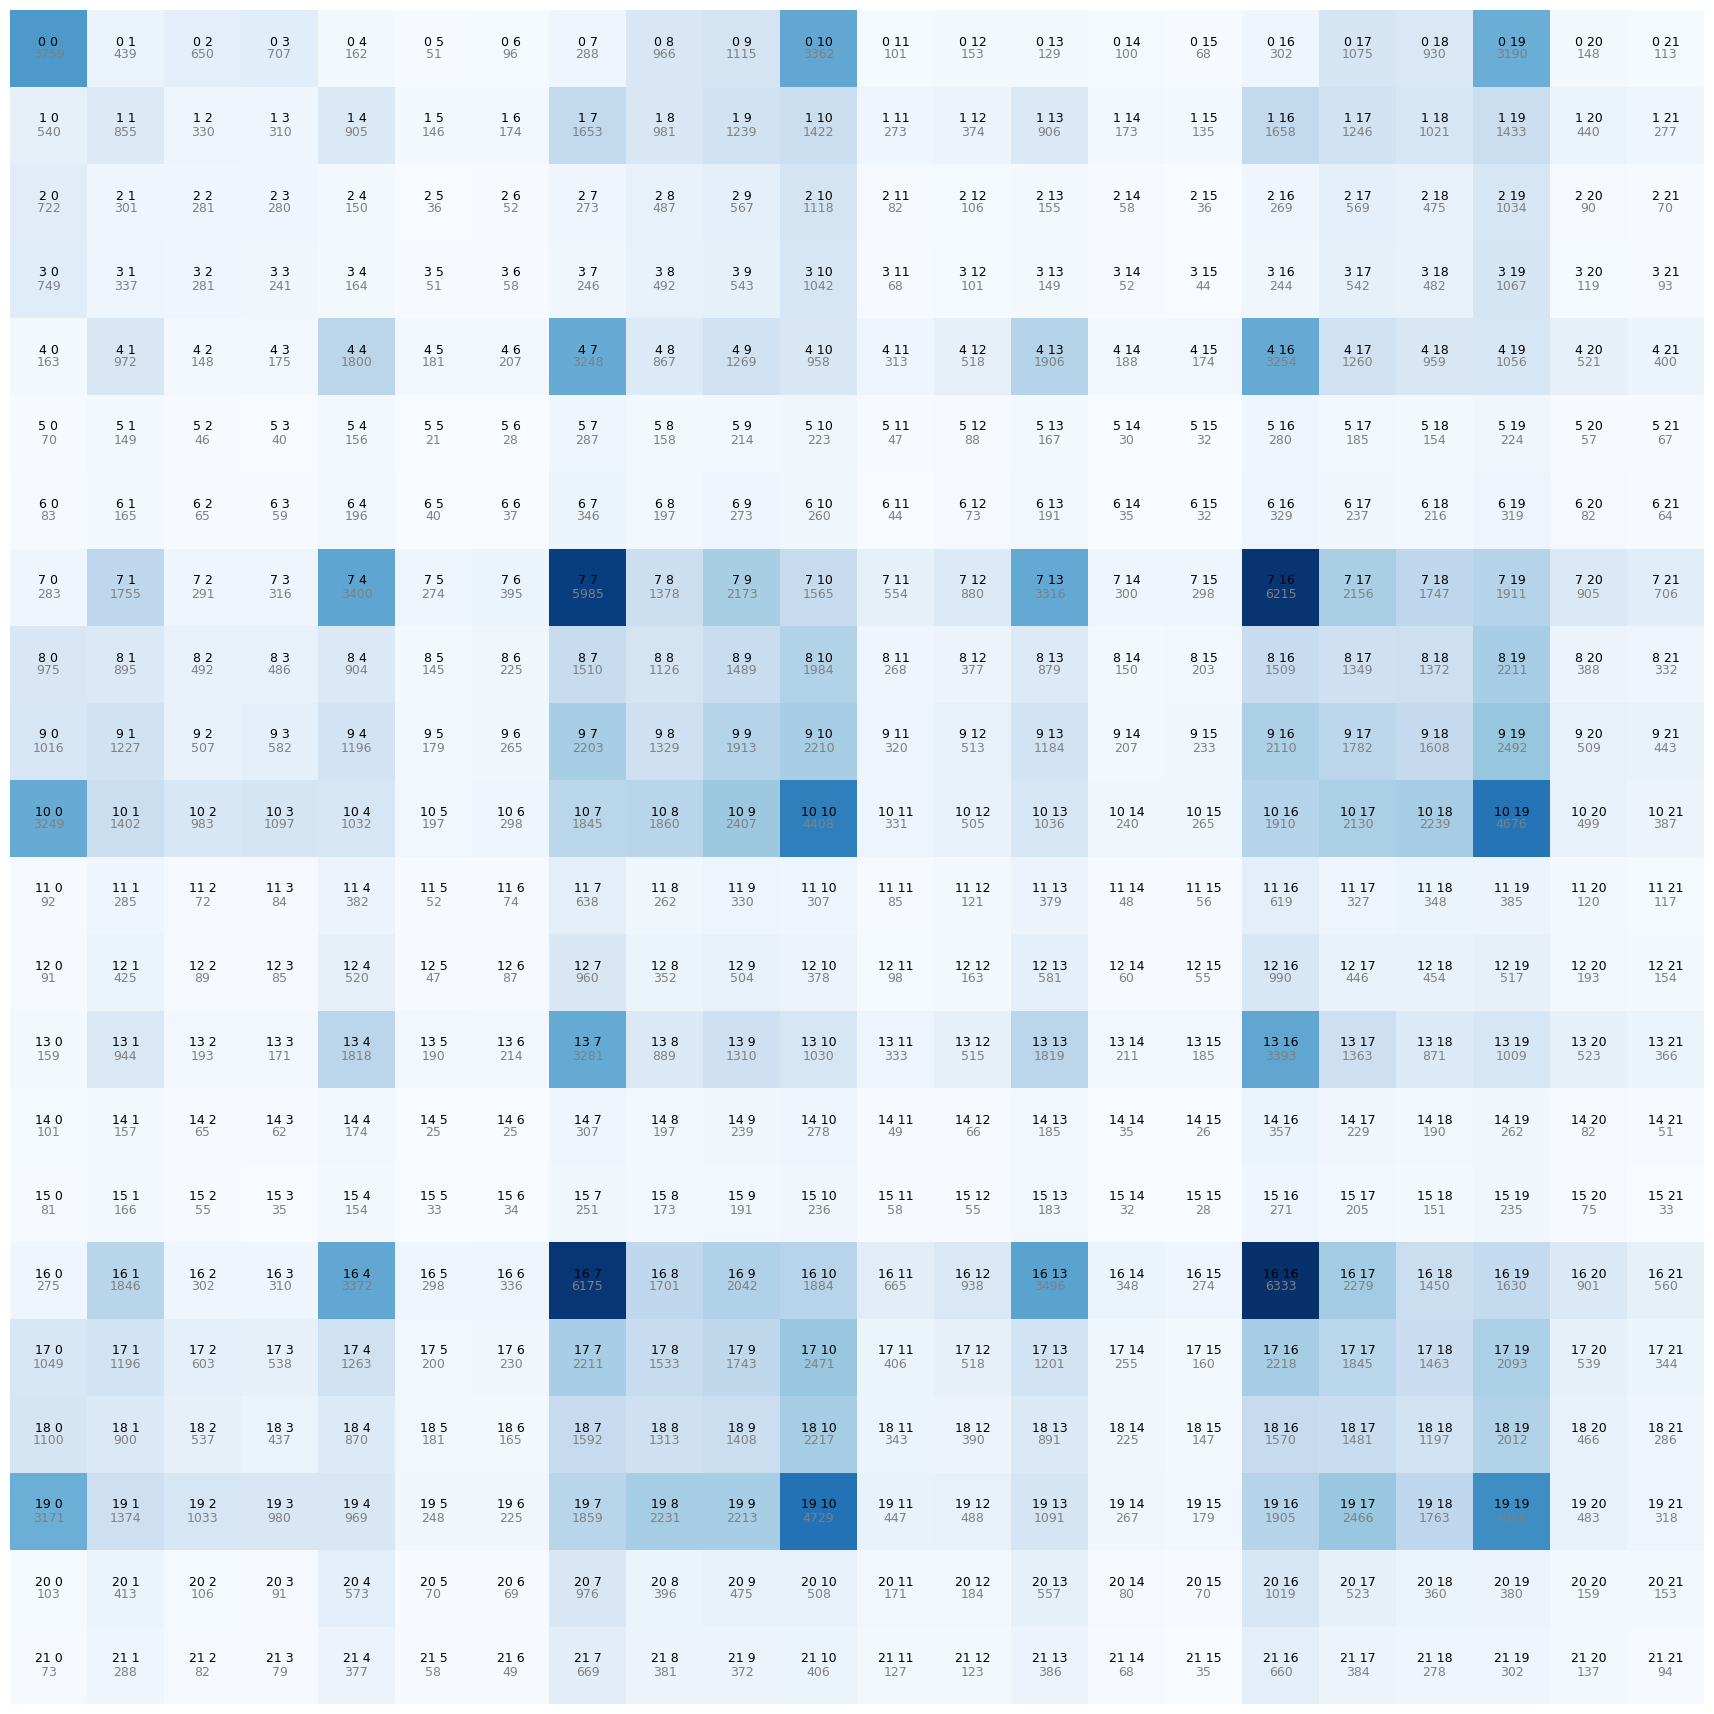

In [11]:
# Plot heatmap with number of possible candle pairs

plt.rcParams.update({'font.size': 9})

plt.figure(figsize=(22,22))
plt.imshow(N, cmap='Blues')
for i in range(n_classes):
    for j in range(n_classes):
        chstr = str(i) + ' ' + str(j)
        plt.text(j, i, chstr, ha="center", va="bottom", color='black')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [13]:
#Initialise Generator

g = torch.Generator().manual_seed(27657)


#### Candles reconstruction
 Here is a try to reconstruct the serions of candles based on what was generation based on candle pair probabilities,
 Sure these is very artificial as the only  generic candle view is reproduces and no size change is considered.
 This is matter of futher project development

In [28]:
#Generate candles sequencies based on pairs probabilities and candle reconstration based on list of candle classes

P = (N).float()+0.01  #Create tensor with pair probabilities 
P /= P.sum(1, keepdims=True)


for i in range(1): 
  out = []
  ix = 0
  for i in range(100):
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(ix)


# function to reconstruct candles

class_features = df1.groupby('class').sample().iloc[:,4:-1].values

cdl = []

for i in range(len(out)):

    candle_features = class_features[out[i]]
    c = {}


    # define candle color and body size & shift for both first and following candles.

    if candle_features[0] == 1:

        if candle_features[3] == 1:
            c = {'open': .0, 'high': .95, 'low': -.05, 'close': .9}
        elif candle_features[4] == 1:
            c = {'open': .0, 'high': 0.75, 'low': -.25, 'close': 0.5}
        elif candle_features[5] == 1:
            c = {'open': .0, 'high': 0.55, 'low': -.45, 'close': 0.2}  

        if candle_features[6] == 1:
            shift = c['high'] - c['close']  
            c['high']  -= shift
            c['low'] -= shift
        elif candle_features[7] == 1:
            shift = c['open'] - c['low']  
            c['low']  += shift
            c['high'] += shift

    elif candle_features[1] == 1:


        if candle_features[3] == 1:
            c = {'open': .0, 'high': .05, 'low': -.95, 'close': -.9}
        elif candle_features[4] == 1:
            c = {'open': .0, 'high': .25, 'low': -.75, 'close': -0.5}
        elif candle_features[5] == 1:
            c = {'open': .0, 'high': .45, 'low': -.55, 'close': -0.25}

        if candle_features[6] == 1:
            shift = c['high'] - c['open']  
            c['high']  -= shift
            c['low'] -= shift
        elif candle_features[7] == 1:
            shift = c['close'] - c['low']  
            c['high']  += shift
            c['low'] += shift

    elif candle_features[2] == 1:
        c = {'open': 0, 'high': .5, 'low': -.5, 'close': 0}
        if candle_features[6] == 1:
            shift = .45  
            c['high']  -= shift
            c['low'] -= shift
        elif candle_features[7] == 1:
            shift = .45  
            c['high']  += shift
            c['low'] += shift
    
    c['class'] = out[i]

    if i == 0:
        
        cdl.append(c)
    else:
        c['open'] += cdl[-1]['close']
        c['high'] += cdl[-1]['close']
        c['low'] += cdl[-1]['close']
        c['close'] += cdl[-1]['close']
        cdl.append(c)
    


In [29]:
##Print candles from the dataset generated based on prediction
cdl_data = pd.DataFrame(cdl)

fig = go.Figure(data=[go.Candlestick(x=cdl_data.index,
                open=cdl_data['open'], high=cdl_data['high'],
                low=cdl_data['low'], close=cdl_data['close'])
                     ])

fig.add_trace(
    go.Scatter(
        x=cdl_data.index,
        y=cdl_data['high'],
        mode= "text",
        
        text = cdl_data['class'],
        textposition = 'top center',
        textfont = {'size':8}))

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

In [25]:
#Print some number of candles from the real dataset with class marks

cdl_data = df1.iloc[100:150]

fig = go.Figure(data=[go.Candlestick(x=cdl_data.index,
                open=cdl_data['open'], high=cdl_data['high'],
                low=cdl_data['low'], close=cdl_data['close'])
                     ])

fig.add_trace(
    go.Scatter(
        x=cdl_data.index,
        y=cdl_data['high'],
        mode= "text",
        
        text = cdl_data['class'],
        textposition = 'top center',
        textfont = {'size':8}))

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()